# Examples

To use `pyinverse` in a project:

## Initialize the package

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from pyinverse.forward_model import Linear
from pyinverse.loss import LeastSquares, Thikonov, Bayesian
from pyinverse.solver import LSTSQ


## Falling stone

Simple example of a linear regression to infer the acceleration of a stone in the gravity field of the earth.

$$
s = \frac{1}{2} a t^2
$$

$$
y = K x
$$

$$
\begin{aligned}
y &= s \\
K &= \frac{1}{2} t^2 \\
x &= a
\end{aligned}
$$

In [4]:
# Measurements
measurements = dict()
measurements["height"] = np.array([1, 2, 3, 4, 5]) # m
measurements["time"] = np.array([0.46, 0.62, 0.78, 0.90, 1.01]) # s

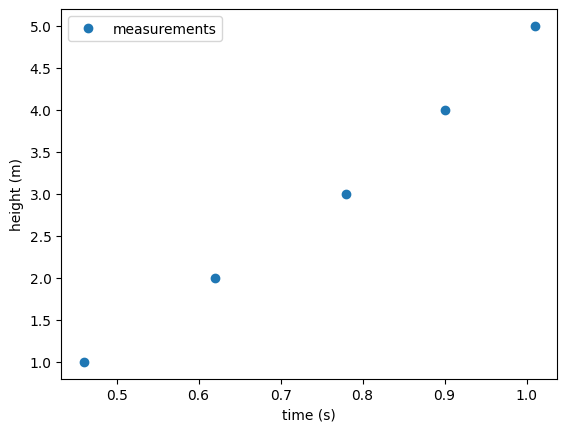

In [5]:
plt.plot(measurements["time"], measurements["height"], "o", label="measurements")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("height (m)")
plt.show()

In [6]:
# Formulate as inverse problem
y = measurements["height"]
K = 0.5 * measurements["time"][:, None] ** 2

In [7]:
# Create forward model
forward_model = Linear(K)
# Loss function
loss = LeastSquares(y, K)
# Solver
solver = LSTSQ(loss)

In [8]:
a = solver()[0]

In [9]:
# Create a prediction for the measurements
y_pred = forward_model(a)

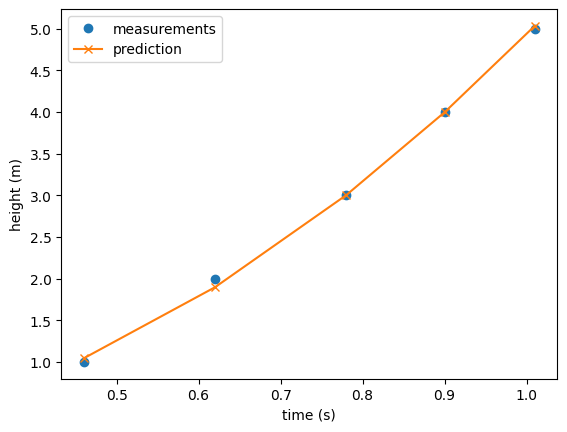

In [10]:
plt.plot(measurements["time"], measurements["height"], "o", label="measurements")
plt.plot(measurements["time"], y_pred, "-x", label="prediction")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("height (m)")
plt.show()

## Diffusion from a point source (Tutorial 6)

Simple example of a linear regression to infer the emissions of a point source in a 3D domain. The point source is located at $(x_0, y_0, z_0)$ with a constant emission rate $E[kg/s]$.

Gaussian diffusion:
$$
    c(x, y, z) = \frac{E}{2\pi\,u_0\,\sigma_y(x)\,\sigma_z(x)} 
    \exp \left( - \frac{(y - y_0)^2}{2 \sigma_y(x)^2} \right) 
    \exp \left( - \frac{(z - z_0)^2}{2 \sigma_z(x)^2} \right)
$$
for $x \geq x_0$

with
$$
    \sigma_{y, z}(x) = \sqrt{2 K_{y, z} t} = \sqrt{2 K_{y, z} \frac{x - x_0}{u_0}}
$$

In [11]:
def exponential(x, x0, sigma):
    return np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def compute_sigma(x, x0, u0, K):
    return np.sqrt(2 * K * (x - x0) / u0)

In [44]:
def compute_con(x, y, z, x0, y0, z0, E, u0, K_y, K_z):
    if x > x0:
        sigma_y = compute_sigma(x, x0, u0, K_y)
        sigma_z = compute_sigma(x, x0, u0, K_z)
        frac = E / (2 * np.pi * u0 *sigma_y * sigma_z)
        exp_y = exponential(y, y0, sigma_y)
        exp_z = exponential(z, z0, sigma_z)
        return frac * exp_y * exp_z
    else:
        return 0

In [45]:
# Wind velocity along the y-axis
u0 = 4 # m/s
# Horizontal dispersion coefficient
K_y = 40. # m^2/s
# Vertical dispersion coefficient
K_z = 10. # m^2/s

# Source location
x0 = 0. # m
y0 = 0. # m
z0 = 200. # m

# Emission rate
E = 10. # kg/s

In [46]:
compute_con(1, 0.2, 200, x0, y0, z0, E, u0, K_y, K_z)

0.03974896692493894

In [53]:
# Visualize the plume
x_mesh, y_mesh = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-200, 200, 100))
con = np.zeros_like(x_mesh)
for i in range(x_mesh.shape[0]):
    for j in range(x_mesh.shape[1]):
        con[i, j] = compute_con(x_mesh[i, j], y_mesh[i, j], 190, x0, y0, z0, E, u0, K_y, K_z)

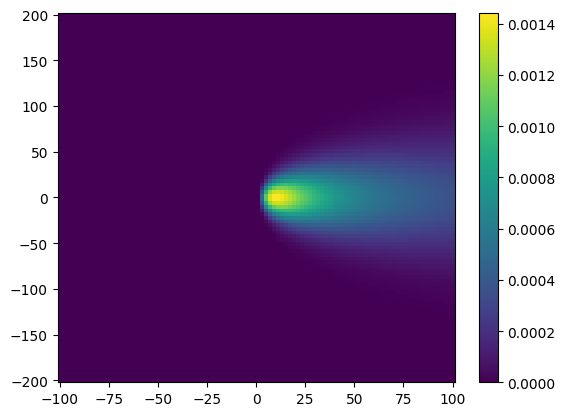

In [54]:
# Plot the plume in log scale
plt.pcolormesh(x_mesh, y_mesh, con)
plt.colorbar()

In [111]:
# Simple forward model
x = np.array([1, 2])  # True state
K = np.array(
    [
        [1, 1],
        [0, 2],
    ]
)  # Forward matrix


In [101]:
forward_model = Linear(K)
y = forward_model(x)  # Measurement
# loss = LeastSquares(y, K)
alpha = 1.0
loss = Thikonov(y, K, alpha)
solver = LSTSQ(loss)  

In [103]:
for alpha in [1, 2, 3]:
    loss.alpha = alpha
    x_est = solver()[0]
    print(x_est)

[0.63636364 1.72727273]
[0.5 1.5]
[0.41935484 1.32258065]


In [104]:
x_est, res, rank, s = solver()

In [105]:
# Compute loss for the measurements
loss(x_est)


9.193548387096774

In [106]:
K @ x_est

array([1.74193548, 2.64516129])

In [107]:
x_est

array([0.41935484, 1.32258065])

In [113]:
x_prior = np.array([0, 1])
cov_prior = np.array([1,2])
loss = Bayesian(y=y, K=K, x_prior=x_prior, cov_prior=cov_prior)

In [114]:
loss(x_est)

4.4687825182101975